In [ ]:
# Installations
%pip install "git+https://github.com/tournesol-app/tournesol.git@solidago-pipeline#egg=solidago&subdirectory=solidago"

In [17]:
# Imports
import math
import time
import colorsys
import warnings

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from datetime import datetime
from matplotlib.axes import Axes
from dateutil.relativedelta import relativedelta
from solidago.pipeline.inputs import TournesolInputFromPublicDataset

In [18]:
PUBLIC_DATASET = TournesolInputFromPublicDataset.download()

-----

# Plot User Graph

In [19]:
USER_TO_PLOT = 'NatNgs'
TIME_TO_RUN = 120 # Seconds, the longer the prettier (but the more time it will take to compute)

In [26]:
user_comparisons = (PUBLIC_DATASET.comparisons[PUBLIC_DATASET.comparisons.public_username == USER_TO_PLOT]
                                  .loc[PUBLIC_DATASET.comparisons.criteria == 'largely_recommended']
                                  [['entity_a', 'entity_b']]
)
user_comparisons_list = zip(user_comparisons['entity_a'], user_comparisons['entity_b'])

graph = nx.Graph()
graph.add_edges_from(user_comparisons_list)
largest_group = max(nx.connected_components(graph), key=len)
graph.remove_nodes_from(n for n in list(graph.nodes) if not n in largest_group)
print('Loaded', graph)

Loaded Graph with 715 nodes and 1716 edges


In [21]:
## Preparing Graph Layout
start = time.time()

# Initialy put all nodes in a circle around the center
pos=nx.circular_layout(graph)

iterations_count=10
total_iterations=0
timer_a = time.time()
loops_count = 0
while timer_a - start < TIME_TO_RUN:
	loops_count += 1
	# Move nodes towards eachother if connected, move them apart from eachother if not connected
	pos = nx.spring_layout(graph, pos=pos, weight='spring', iterations=iterations_count)
	total_iterations += iterations_count
	timer_b = time.time()
	speed = iterations_count / (timer_b-timer_a)
	expected_remaining_iterations = speed * (TIME_TO_RUN - timer_b + start)
	print(f"Iterations: {total_iterations}/{total_iterations + expected_remaining_iterations:.0f} -- Time: {timer_b-start:.1f}/{TIME_TO_RUN}s -- Speed: {speed:.1f}/s")
	next_iteration_count = int(math.ceil(expected_remaining_iterations / (10 - loops_count if loops_count < 10 else 1)))
	if loops_count > 10 or next_iteration_count > iterations_count*2 and loops_count > 1:
		# Spring Layout may stop iterating if found an equilibrium. Try to detect this event and stop before max_duration
		break
	# Prepare next iteration
	iterations_count = next_iteration_count
	timer_a = timer_b

end = time.time()
print()

Iterations: 10/1360 -- Time: 0.9/120s -- Speed: 11.3/s
Iterations: 161/2527 -- Time: 8.0/120s -- Speed: 21.1/s
Iterations: 457/2508 -- Time: 22.2/120s -- Speed: 21.0/s
Iterations: 751/2509 -- Time: 36.2/120s -- Speed: 21.0/s
Iterations: 1044/2526 -- Time: 50.0/120s -- Speed: 21.2/s
Iterations: 1341/2519 -- Time: 64.1/120s -- Speed: 21.1/s
Iterations: 1636/2519 -- Time: 78.1/120s -- Speed: 21.1/s
Iterations: 1931/2507 -- Time: 92.3/120s -- Speed: 20.8/s
Iterations: 2219/2478 -- Time: 106.9/120s -- Speed: 19.7/s
Iterations: 2479/2478 -- Time: 120.1/120s -- Speed: 19.7/s



min & max colors: 1 11
Image size: 8.2x6.2


<Figure size 640x480 with 0 Axes>

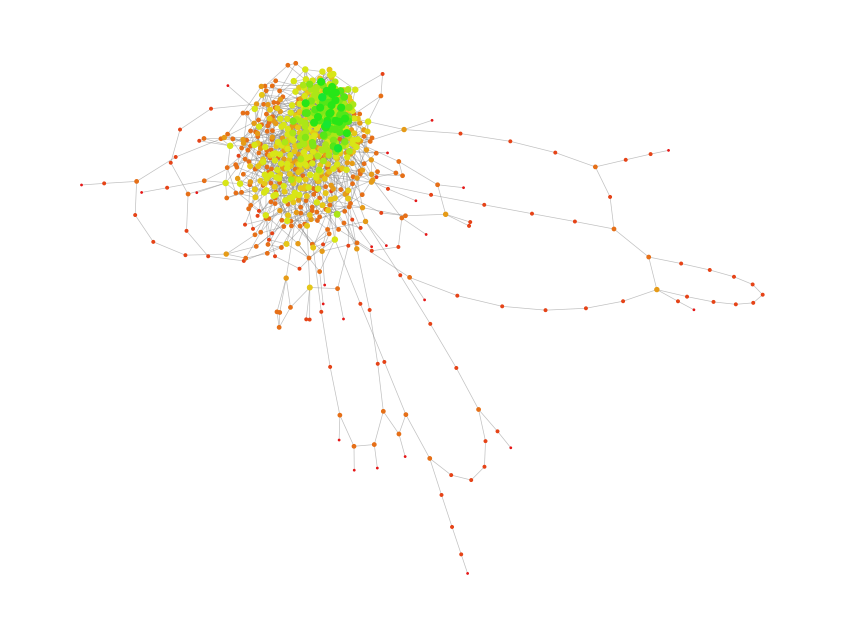

In [22]:
# Order nodes by color
colors_map = {n: len(graph[n]) for n in graph.nodes}
nodes = sorted(graph.nodes, key=colors_map.get)
sorted_graph = nx.Graph()
sorted_graph.add_nodes_from(nodes)
sorted_graph.add_edges_from(graph.edges.data())

# node color
min_c = min(colors_map.values())
mm_c = max(colors_map.values()) - min_c
print('min & max colors:', min_c, min_c + mm_c)

# Make colors from red(min) to green(max)
colors = [colorsys.hsv_to_rgb((colors_map[n]-min_c)/mm_c * (128/360), .9, .9) for n in nodes]

# Prepare image
plt.box(False)
plt.clf()
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('axes', unicode_minus=False)

# Output svg dimensions
size = (sorted_graph.number_of_nodes()+1)**0.25
print(f"Image size: {size*1.4+1:.1f}x{size+1:.1f}")
fig = plt.figure(figsize=(size*1.4+1, size+1), frameon=False)

# Axis
fig.clear()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.set_facecolor('#FFF') # Background color

nodes_width = {n:d for n,d in graph.degree}
min_w = min(nodes_width.values())
mm_w = max(nodes_width.values()) - min_w
min_display = 1
mm_display = 25 - min_display
nx.draw_networkx_nodes(sorted_graph,
	pos=pos,
	nodelist=nodes,
	node_size=[min_display+mm_display*(nodes_width[n]-min_w)/mm_w for n in nodes],
	node_color=colors
)

nx.draw_networkx_edges(sorted_graph,
	pos=pos,
	edge_color='#8888',
	width=0.5,
)

warnings.filterwarnings("ignore", category=UserWarning)

-----

# Active Users

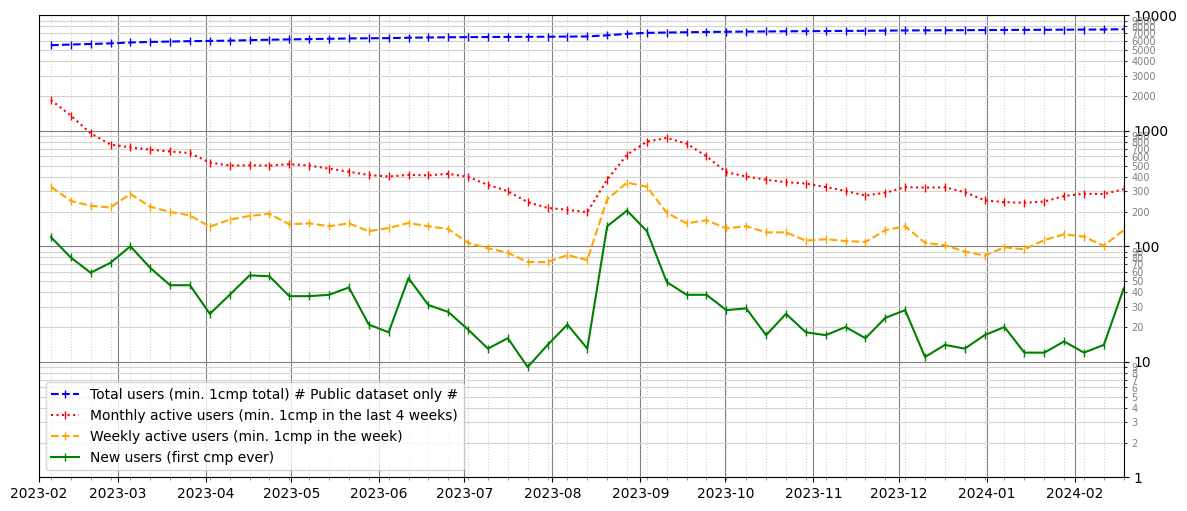

In [23]:
## User count over time
def usercount_graph():
	actives:dict[str,set[str]] = PUBLIC_DATASET.comparisons.groupby('week_date')['public_username'].unique().aggregate(set).to_dict() # date:{user, ...}
	account_creation:dict[str,str] = PUBLIC_DATASET.comparisons.groupby('public_username')['week_date'].min().to_dict() # user: date

	activesmonth: dict[str, set[str]] = dict() # date:{user, ...}
	l_dates: list[str] = sorted(actives.keys())
	for i in range(4,len(l_dates)):
		activesmonth[l_dates[i]] = actives[l_dates[i]].union(actives[l_dates[i-1]]).union(actives[l_dates[i-2]]).union(actives[l_dates[i-3]])

	one_year_ago = (datetime.now() - relativedelta(years=1, weeks=5)).isoformat()

	dates = [d for d in l_dates if d > one_year_ago]

	l_total: list[int] = [len([a for a in account_creation if account_creation[a] <= d]) for d in dates]
	l_actives_4: list[int] = [len(activesmonth[d]) for d in dates[1:]]
	l_actives: list[int] = [len(actives[d]) for d in dates[1:]]
	l_news: list[int] = [l_total[i] - l_total[i-1] for i in range(1,len(l_total))]
	l_datetimes: list[datetime] = [datetime.fromisoformat(k) for k in dates[1:]]
	l_total.pop(0)


	fig, ax = plt.subplots()
	fig.set_size_inches(14, 6)
	ax.set_yscale('log')
	ax.set_ylim(ymin=1, ymax=10**math.ceil(np.log10(l_total[-1])))
	ax.set_xlim(xmin=l_datetimes[1], xmax=l_datetimes[-1])
	ax.yaxis.set_ticks_position('right')
	ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
	ax.yaxis.set_minor_formatter(mtick.ScalarFormatter())
	ax.yaxis.set_tick_params('minor', labelsize=7, labelcolor='gray')

	myFmt = mdates.DateFormatter('%Y-%m')
	ax.xaxis.set_ticks(pd.date_range(one_year_ago, datetime.now(), freq='MS'))
	ax.xaxis.set_major_formatter(myFmt)
	ax.xaxis.set_ticks(l_datetimes, minor=True)
	ax.xaxis.set_tick_params('minor', color='gray')
	ax.grid(visible=True, which='major', axis='y', color='gray')
	ax.grid(visible=True, which='minor', axis='y', color='lightgray')
	ax.grid(visible=True, which='major', axis='x', color='gray')
	ax.grid(visible=True, which='minor', axis='x', color='lightgray', linestyle=':')
	ax.plot_date(l_datetimes, l_total, xdate=True, color='blue', fmt='|--', label='Total users (min. 1cmp total) # Public dataset only #')
	ax.plot_date(l_datetimes, l_actives_4, xdate=True, color='red', fmt='|:', label='Monthly active users (min. 1cmp in the last 4 weeks)')
	ax.plot_date(l_datetimes, l_actives, xdate=True, color='orange', fmt='|--', label='Weekly active users (min. 1cmp in the week)')
	ax.plot_date(l_datetimes, l_news, xdate=True, fmt='|-', color='green', label='New users (first cmp ever)')
	ax.legend()
usercount_graph()

-----

# All users Videos vs Comparisons Scatter

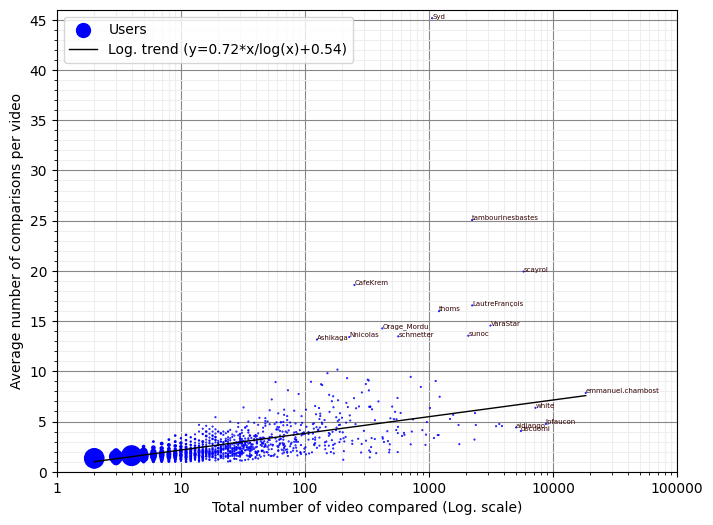

In [28]:
## Users comparisons graph
plt.rc('axes', unicode_minus=False)
def users_cmp_graph():
	recom = PUBLIC_DATASET.get_comparisons(criteria='largely_recommended')
	mirrored = pd.concat([recom.rename(columns={'entity_a': 'vid', 'entity_b': 'comparedwith'}), recom.rename(columns={'entity_a': 'comparedwith', 'entity_b': 'vid'})], ignore_index=True)
	
	videos_per_user = recom.groupby('user_id')[['entity_a']].count().rename(columns={'entity_a': 'videos'})
	cmps_per_video_per_user = mirrored[['user_id', 'vid', 'comparedwith']].groupby(['user_id', 'vid']).count().groupby('user_id').mean().rename(columns={'comparedwith': 'averagecmps'})

	data = (videos_per_user.join(cmps_per_video_per_user, on='user_id')
	                       .join(PUBLIC_DATASET.users, on='user_id')
	                       .rename(columns={'videos': 'x', 'averagecmps': 'y'})
						   [['public_username', 'x', 'y']]
	)
	data = data[data.x > 1]
	sizes = data.groupby(['x', 'y']).count().rename(columns={'public_username': 's'})
	polyfit = data.groupby(lambda _: True).apply(lambda l: np.polyfit(np.log(l.x), l.y, 1))[True]

	fig, ax = plt.subplots()
	fig.set_size_inches(8, 6)

	#ax.set_yscale('log')
	ax.set_xscale('log')
	ax.yaxis.set_major_formatter(mtick.ScalarFormatter())
	ax.xaxis.set_major_formatter(mtick.ScalarFormatter())
	
	ymax = data['y'].max()
	xmax = data['x'].max()
	ax.set_xlim(xmin=1, xmax=10**math.ceil(math.log10( xmax )))
	y_ticks_spacing = math.ceil(( ymax - data['y'].min() )/10)
	ax.yaxis.set_ticks(np.arange(0, (1+round(ymax/y_ticks_spacing))*y_ticks_spacing, y_ticks_spacing))
	ax.yaxis.set_ticks(np.arange(0, (1+round(ymax)), 1), minor=True)
	ax.set_axisbelow(True)

	sizes.reset_index().plot.scatter(x='x', y='y', c='blue', marker='.', s='s', label='Users', ax=ax)

	for _,row in data.iterrows():
		x= row['x']
		y= row['y']
		if y > 12 or x > 5000:
			ax.annotate(row['public_username'], (x, y), fontsize=5, color="#300")

	###########################################


	poly_xx = [2, xmax]
	poly_yy = [1, polyfit[0]*math.log(xmax)+polyfit[1]]
	ax.plot(poly_xx, poly_yy, color='#000', linewidth=1, label=f"Log. trend (y={polyfit[0]:0.2f}*x/log(x){polyfit[1]:+0.2f})")
	ax.set_ylim(ymin=0, ymax=math.floor(ymax)+1)


	# plt.title('How many comparisons every Tournesol users have done')
	ax.legend(loc='upper left')
	ax.set_ylabel('Average number of comparisons per video')
	ax.set_xlabel('Total number of video compared (Log. scale)')
	ax.grid(visible=True, which='major', axis='both', color='#888')
	ax.grid(visible=True, which='minor', axis='both', color='#eee')
	
users_cmp_graph()

-----

# User Graph

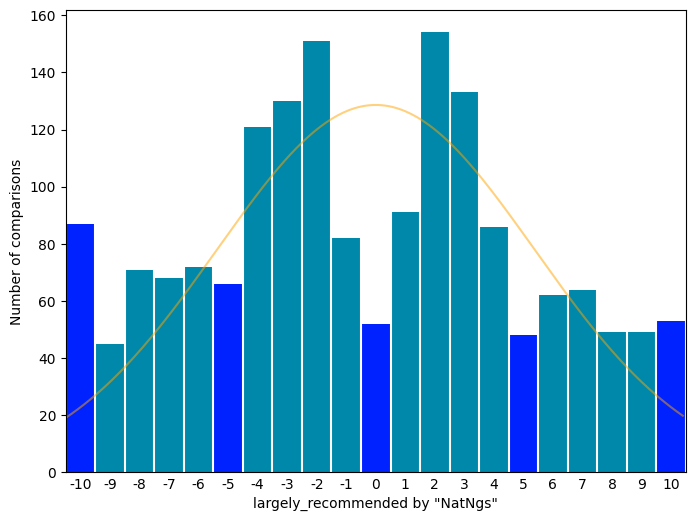

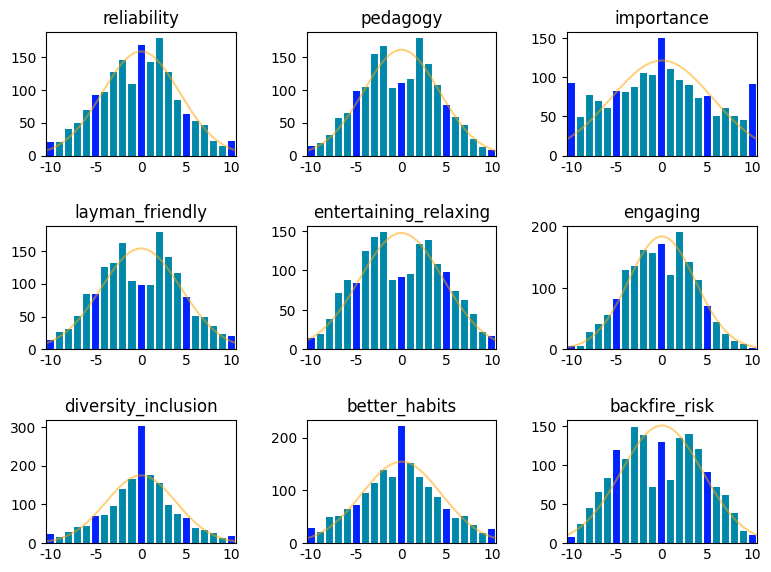

In [25]:
# User cursors position
USER='NatNgs'

def user_histogram(ax: Axes, username: str, CRITERION: str, title: bool=False):
	votes = PUBLIC_DATASET.comparisons[PUBLIC_DATASET.comparisons.public_username == username].loc[PUBLIC_DATASET.comparisons.criteria == CRITERION].score

	ax.set_axisbelow(True)

	ax.set_xlim(xmin=-10.5, xmax=10.5)
	ax.xaxis.set_ticks(range(-10,11,1 if title else 5))
	ax.tick_params(axis='x', length=0)

	counts, bins = np.histogram(votes, bins=21)
	bins = [i/10.0 for i in range(-105,106,10)]
	counts_highlights = [(b if i%5 == 0 else 0) for i,b in enumerate(counts, -10)]
	counts_others = [(b if i%5 != 0 else 0) for i,b in enumerate(counts, -10)]

	ax.hist(bins[:-1], bins, weights=counts_others, align='mid', color='#0088AA')
	ax.hist(bins[:-1], bins, weights=counts_highlights, align='mid', color='#0022FF')
	for i in bins: # Plot white lines to separate columns
		ax.axvline(i, color='white')

	# plt.title('How many comparisons every Tournesol users have done')
	if title:
		ax.set_xlabel(CRITERION + ' by "' + USER + '"')
		ax.set_ylabel('Number of comparisons')
	else:
		ax.set_title(CRITERION)

	# Plot orange bell curve
	stdv = np.std(votes)
	reg_x = np.arange(-10.5, 10.5, 0.1)

	reg_y = np.exp(-np.square(reg_x/stdv)/2)/(stdv*np.sqrt(2*np.pi)) * len(votes)
	ax.plot(reg_x, reg_y, color='orange', alpha=.5)

	ax.set_ylim(bottom=0)



fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
user_histogram(ax, USER, 'largely_recommended', True)

fig, ax = plt.subplots(3,3)
user_histogram(ax[0][0], USER, 'reliability')
user_histogram(ax[0][1], USER, 'pedagogy')
user_histogram(ax[0][2], USER, 'importance')
user_histogram(ax[1][0], USER, 'layman_friendly')
user_histogram(ax[1][1], USER, 'entertaining_relaxing')
user_histogram(ax[1][2], USER, 'engaging')
user_histogram(ax[2][0], USER, 'diversity_inclusion')
user_histogram(ax[2][1], USER, 'better_habits')
user_histogram(ax[2][2], USER, 'backfire_risk')
fig.tight_layout()
fig.set_size_inches(8, 6)